<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Coronavirus Dataset Classification.</h1>
</div>

<strong>Content:</strong>

1. Load the Data.
    + Importing Libraries.
    + Loading the data
2. Exploratory Data Analysis.
3. Text Processing.
4. Building the Classifier.
    + Implementing callbacks
    + Training history
5. Model evaluation.

The dataset used in this project can be found in this [link](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification?select=Corona_NLP_test.csv).

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Load the Data</h2>
</div>

In this section you will:

- Import the libraries.
- Load the dataset.

### 1.1 Import Libraries

In [1]:
import os
import io
import re
import string

import pandas as pd
import numpy as np

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for machine learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout, LSTM, GlobalMaxPool1D
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report

### Loading data set.

In [2]:
# train dataset
df_train = pd.read_csv("data/Corona_NLP_train.csv", encoding = "ISO-8859-1")
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
def finding_null_values(df):
    for column in df_train.columns:
        null_values = df_train[column].isnull().sum()
        if  null_values > 0:
            print(f"Column '{column}' has: {null_values}")

In [4]:
#Null values in train dataset
finding_null_values(df_train)

Column 'Location' has: 8590


In [5]:
# Test dataset
df_test = pd.read_csv("data/Corona_NLP_test.csv", encoding = "ISO-8859-1")
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
#Null values in test dataset
finding_null_values(df_test)

Column 'Location' has: 8590


As we can see the column "Location" has `null` values, however, in this scenario I'm going to use just the columns `OriginalTweet` and `Sentiment`

In [7]:
#cleaning reviews which are spaces
def removing_empty_tweets(df):
    spaces = []
    for i,user_name,screen_name, location, tweet_at,tweet, sentiment in df_train.itertuples():
        if tweet_at.isspace():
            spaces.append(i)
    if spaces:
        df.drop(spaces, inplace = True)
    else:
        print("No empty tweets were found!")
    
    return df

In [8]:
df_train = removing_empty_tweets(df_train)

No empty tweets were found!


In [9]:
df_test = removing_empty_tweets(df_test)

No empty tweets were found!


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Exploratory Data Analysis.
</div>

In [10]:
df_train["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

## Cleaning tweets

In [11]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string


def clean_text(raw_html:str) -> str:
    '''Clean raw html.
    Input:    raw_html    Text with HTML tags
    return:   clean_text  Clean text
    
    '''
    pattern = re.compile('<.*?>')
    clean_text = re.sub(pattern, '', raw_html)
    clean_text = re.sub(r"http\S+","",clean_text)
    clean_text = re.sub("@[A-Za-z0-9_]+","", clean_text)
    clean_text = re.sub("#[A-Za-z0-9_]+","", clean_text)
    clean_text = clean_text.lower()
    clean_text = re.sub(r'([!?.]){2,}',"", clean_text)
    clean_text = re.sub(r'<3',"heart",clean_text)
    clean_text = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*',"",clean_text)
    
    clean_text = ''.join([word for word in clean_text if word in string.printable])
    
    #removing emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    clean_text = emoji_pattern.sub(r"",clean_text)
    
    #removing sad faces
    clean_text = re.sub(r'[8:=;][\'\-]?[(\\/]',"sadface",clean_text)
    
    #removing smileys 
    clean_text = re.sub(r'[8:=;][\'\-]?[)dDp]',"smile",clean_text)
    
    #removing puntuaction
    table = str.maketrans('','',string.punctuation)
    clean_text = clean_text.translate(table)
    clean_text = replace_abbrev(clean_text) 
    return clean_text   

In [12]:
#cleaning train and test datasets
df_train["clean_tweet"] = df_train["OriginalTweet"].apply(clean_text)
df_test["clean_tweet"] = df_test["OriginalTweet"].apply(clean_text)

## Tweet Length.

In [13]:
df_train["tweet_length"] = df_train["OriginalTweet"].apply(lambda x:len(x))
df_train["clean_tweet_length"] = df_train["clean_tweet"].apply(lambda x:len(x))

df_test["tweet_length"] = df_test["OriginalTweet"].apply(lambda x:len(x))
df_test["clean_tweet_length"] = df_test["clean_tweet"].apply(lambda x:len(x))

#### Training Dataset

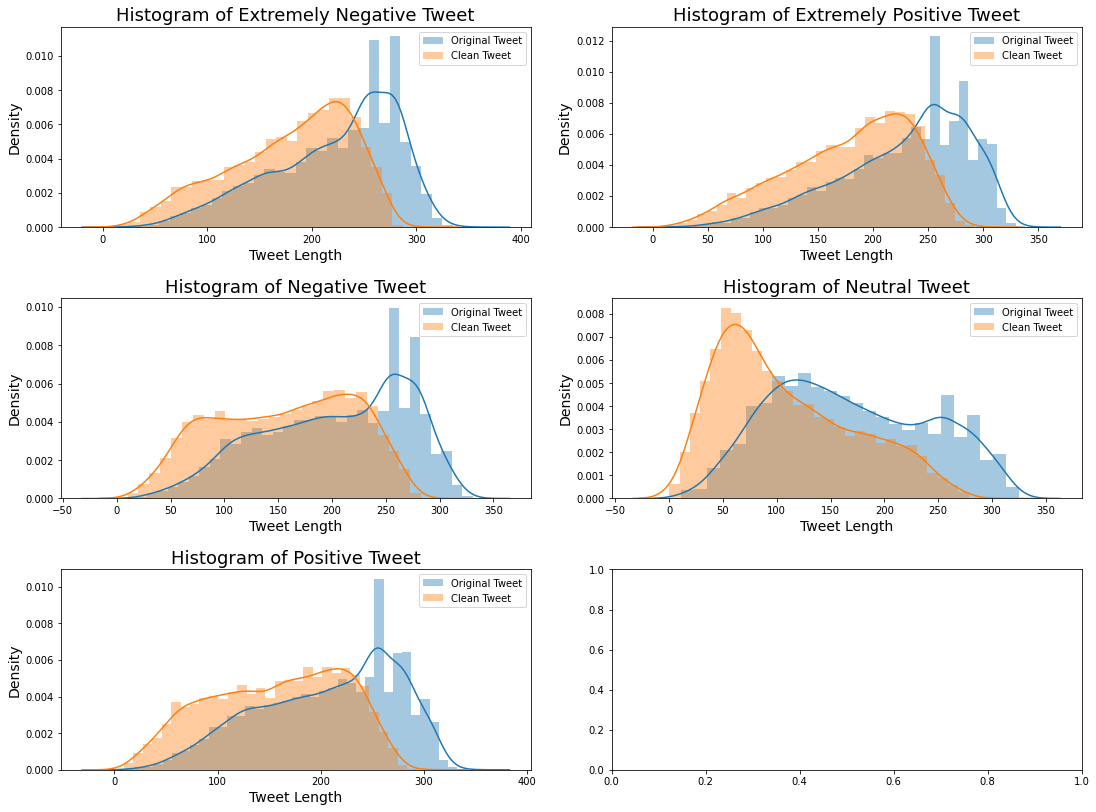

In [14]:
fig, axs = plt.subplots(3,2, figsize = (16,12))
fig.tight_layout(pad=5.0)

labels = np.unique(df_train["Sentiment"])
count = 0
for ax in axs:
    for a in ax:
        sns.distplot(df_train[df_train["Sentiment"]==labels[count]]["tweet_length"], ax = a, label = "Original Tweet")
        sns.distplot(df_train[df_train["Sentiment"]==labels[count]]["clean_tweet_length"], ax = a, label = "Clean Tweet")
        a.set_title(f"Histogram of {labels[count]} Tweet", fontsize = 18)
        a.set_xlabel("Tweet Length", fontsize = 14)
        a.set_ylabel("Density", fontsize = 14)
        a.legend(loc = "best")
        count += 1
        if count >= len(labels):
            break

## Word Count

In [15]:
df_train["count_word"] = df_train["OriginalTweet"].apply(lambda x : len(x.split(" ")))
df_train["clean_count_word"] = df_train["clean_tweet"].apply(lambda x : len(x.split(" ")))

df_test["count_word"] = df_test["OriginalTweet"].apply(lambda x : len(x.split(" ")))
df_test["clean_count_word"] = df_test["clean_tweet"].apply(lambda x : len(x.split(" ")))

#### Training Dataset

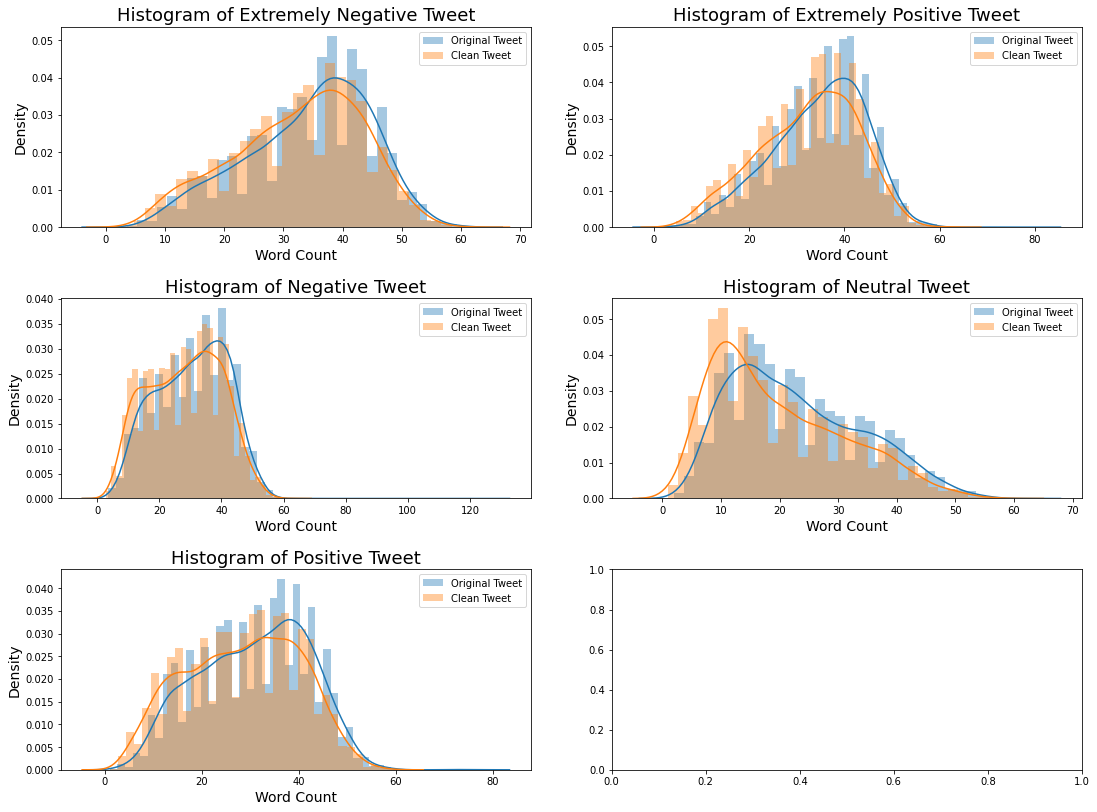

In [16]:
fig, axs = plt.subplots(3,2, figsize = (16,12))
fig.tight_layout(pad=5.0)

count = 0
for ax in axs:
    for a in ax:
        sns.distplot(df_train[df_train["Sentiment"]==labels[count]]["count_word"], ax = a, label = "Original Tweet")
        sns.distplot(df_train[df_train["Sentiment"]==labels[count]]["clean_count_word"], ax = a, label = "Clean Tweet")
        a.set_title(f"Histogram of {labels[count]} Tweet", fontsize = 18)
        a.set_xlabel("Word Count", fontsize = 14)
        a.set_ylabel("Density", fontsize = 14)
        a.legend(loc = "best")
        count += 1
        if count >= len(labels):
            break

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

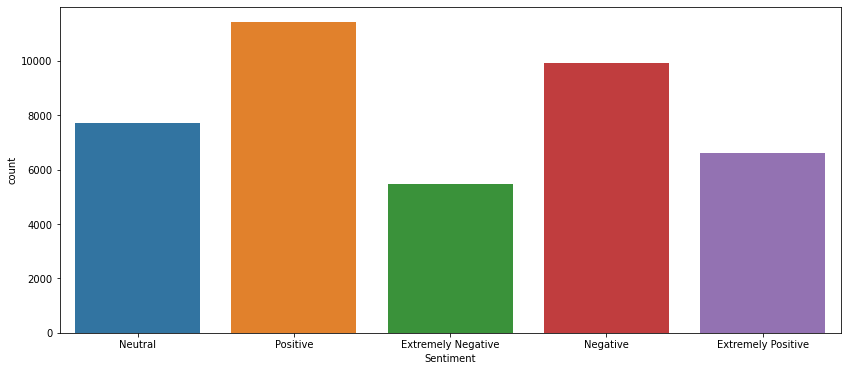

In [17]:
plt.figure(figsize=(14,6))
sns.countplot(df_train["Sentiment"])

Let's focus just on classifying the sentiment instead of the intensity of the sentiment. I am going to group labels with the same sentiments without regarding the intensity of them. The next function is in charge of doing that.

In [18]:
def labeling(tweet):
    if tweet in ['Extremely Negative','Negative']:
        return 0
    elif tweet in ['Extremely Positive','Positive']:
        return 1
    else:
        return 2

In [19]:
df_test["label"] = df_test["Sentiment"].apply(labeling)
df_train["label"] = df_train["Sentiment"].apply(labeling)

#### Training Data

<AxesSubplot:xlabel='label', ylabel='count'>

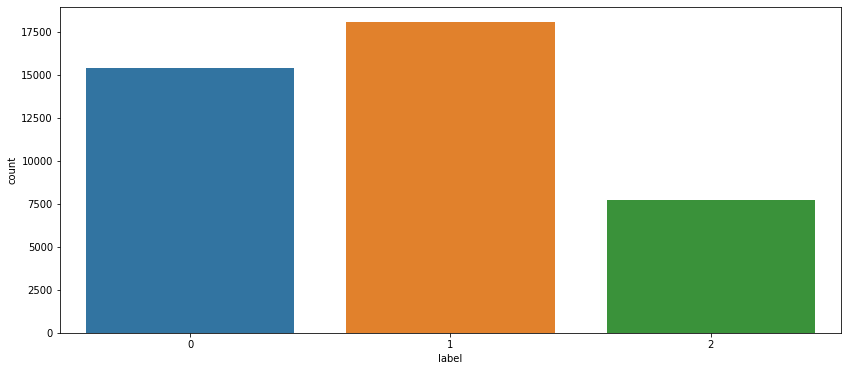

In [20]:
plt.figure(figsize=(14,6))
sns.countplot(df_train["label"])

#### Testing Data

<AxesSubplot:xlabel='label', ylabel='count'>

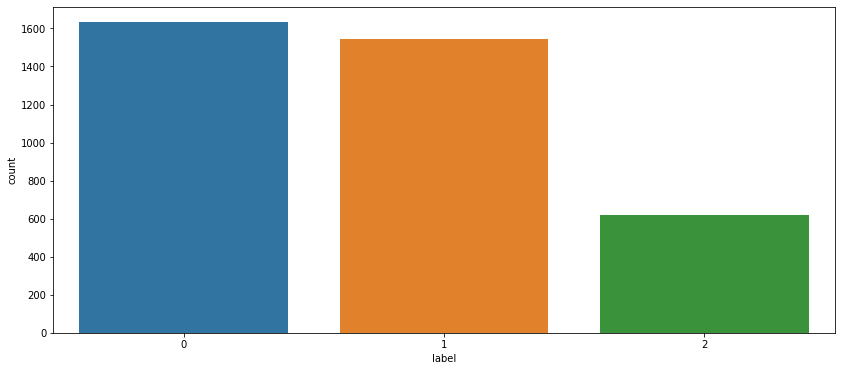

In [21]:
plt.figure(figsize=(14,6))
sns.countplot(df_test["label"])

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Text Processing.</div>

In [22]:
#length of the tweet
maxlen = 60

#to training the model
training_samples = len(df_train)

#to test the model
validation_samples = len(df_test)

#The max number of words to keep
max_words = 10000

texts_train = df_train["clean_tweet"]
labels_train = df_train["label"].values

texts_test = df_test["clean_tweet"]
labels_test = df_test["label"].values

#Tokenization
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts_train)

In [23]:
#word index
word_index = tokenizer.word_index

#creating sequences.
train_sequences = tokenizer.texts_to_sequences(texts_train)
test_sequences = tokenizer.texts_to_sequences(texts_test)

#padding the sequences (maxlen was defined previously, here maxlen =100)
data_train = pad_sequences(train_sequences, maxlen = maxlen)
data_test = pad_sequences(test_sequences, maxlen = maxlen)

#word index revers to maps indexes to words
word_index_reverse = {val:key for key,val in word_index.items()}

In [24]:
#word index revers to maps indexes to words
word_index_reverse = {val:key for key,val in word_index.items()}

for i in range(1,4):
    print("\n")
    print("Index Sequence:")
    print(data_train[i])
    print("\n")
    print("Text Sequence:")
    text_sequence = [word_index_reverse[idx] if idx != 0 else "-" for idx in data_train[i]]
    print(' '.join(text_sequence))



Index Sequence:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  488  848    2   32 2453
  261    2 2752  855 1188 1053  427  373   20  855 1188    4 2453 1176
 3553 3382 4458  471   41   50   49 2238   47 2983  188    4 1006 3055
   48   33  108  226]


Text Sequence:
- - - - - - - - - - - - - - - - - - - - - - - advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if adequate supplies of regular meds but not over order


Index Sequence:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   79  934 4459    2  299  324 1416 1744   49
  253  155   10  134]


Text Sequence:
- - - - - - - - - - - - - - - - - - - -

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Building the classifier.</div>
    

## Transfer Learning + Ebedding + LSTM

**Downloading the GloVe embedding database:**

In this example I am going to use a precomputed embedding from 2014 English Wikipedia. It's an 822 MB zip file called [glove.6B.zip](https://nlp.stanford.edu/projects/glove/) 

In [25]:
#GloVe  embedding directory
glove_dir = "glove/glove.6B.100d.txt"

#Parsing the text file
embeddings_index = {}

f = open(glove_dir)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


#### Preparing the GloVe word-embeddings matrix


In [26]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words,embedding_dim))
for word , i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Creating a sequential model

In [27]:
model_tl = Sequential()
model_tl.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_tl.add(LSTM(64,return_sequences=True))
model_tl.add(GlobalMaxPool1D())
model_tl.add(Dense(32, activation='relu'))
model_tl.add(Dense(3, activation='softmax'))
model_tl.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=["acc"])
model_tl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 60, 64)            42240     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,044,419
Trainable params: 1,044,419
Non-trainable params: 0
_________________________________________________________________


In [28]:
#setting the weights
model_tl.layers[0].set_weights([embedding_matrix])

#freezing the layer
model_tl.layers[0].trainable = False

In [29]:
#weights to use during the training process.
total = len(df_train)

nnegative = len(df_train[df_train["label"]==0])
npositive = len(df_train[df_train["label"]==1])
nneutral = len(df_train[df_train["label"]==2])

weight_for_0 = (1 / nnegative) * (total / 2.0)
weight_for_1 = (1 / npositive) * (total / 2.0)
weight_for_2 = (1 / nneutral) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}

# callbacks

#implementing early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                              restore_best_weights=True)

#reduceOnplateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                  patience=2, min_lr=0.00001,verbose=1)


#fitting the model
history_tl = model_tl.fit(data_train,labels_train,
    epochs=100,
    batch_size=32,
    validation_data = (data_test,labels_test),
    callbacks = [early_stop,reduce_lr],
    class_weight=class_weight
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
1287/1287 [==============================] - 64s 48ms/step - loss: 0.8887 - acc: 0.7662 - val_loss: 0.4566 - val_acc: 0.8576
Epoch 2/100
1287/1287 [==============================] - 65s 50ms/step - loss: 0.4959 - acc: 0.8978 - val_loss: 0.3698 - val_acc: 0.8797
Epoch 3/100
1287/1287 [==============================] - 59s 46ms/step - loss: 0.3799 - acc: 0.9229 - val_loss: 0.3498 - val_acc: 0.8878
Epoch 4/100
1287/1287 [==============================] - 64s 50ms/step - loss: 0.3011 - acc: 0.9387 - val_loss: 0.3700 - val_acc: 0.8768
Epoch 5/100
1287/1287 [==============================] - 88s 68ms/step - loss: 0.2302 - acc: 0.9536 - val_loss: 0.3909 - val_acc: 0.8826

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/100
1287/1287 [==============================] - 85s 66ms/step - loss: 0.1350 - acc: 0.

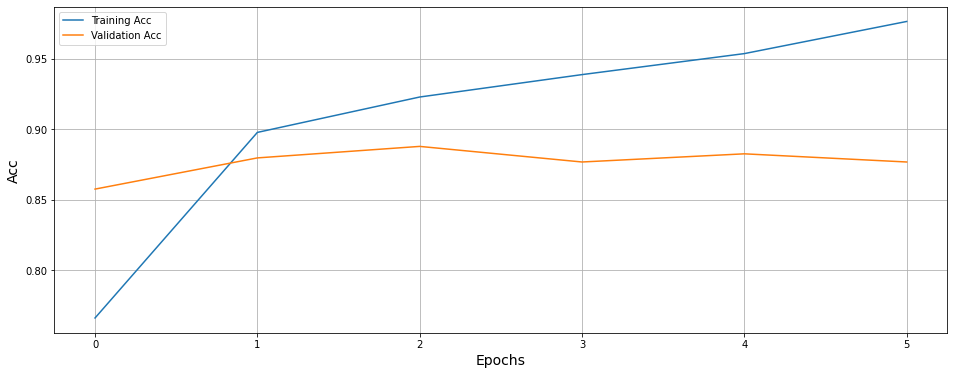

In [30]:
plt.figure(figsize=(16,6))
plt.plot(history_tl.history["acc"],label = "Training Acc")
plt.plot(history_tl.history["val_acc"],label = "Validation Acc")
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Acc", fontsize = 14)
plt.legend(loc ="best")
plt.grid()

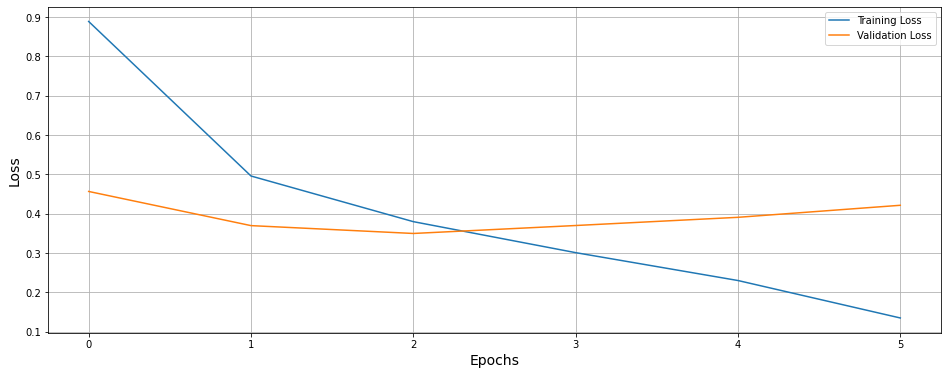

In [31]:
plt.figure(figsize=(16,6))
plt.plot(history_tl.history["loss"],label = "Training Loss")
plt.plot(history_tl.history["val_loss"],label = "Validation Loss")
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.legend(loc ="best")
plt.grid()

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Model Evaluation.</div>
    

In [32]:
predictions_tl = model_tl.predict(data_test)
print(classification_report(np.argmax(predictions_tl,axis = 1),labels_test))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1612
           1       0.90      0.88      0.89      1592
           2       0.85      0.89      0.87       594

    accuracy                           0.89      3798
   macro avg       0.88      0.89      0.88      3798
weighted avg       0.89      0.89      0.89      3798



In [33]:
model_tl.save("model_embeddings_tl.h5")